<a href="https://colab.research.google.com/github/dsanroman96/Machine-Learning-Projects/blob/main/House_Price_Prediction_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import inf
import scipy.stats as stats
from scipy.stats import skew, norm
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Supervised_ML/House Price Prediction/house-prices-dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Supervised_ML/House Price Prediction/house-prices-dataset/test.csv")
test_final = test_df
aim = pd.read_csv("/content/drive/MyDrive/Supervised_ML/House Price Prediction/house-prices-dataset/best_submission.csv")

## Data Exploration

In [ ]:
def correlation_info(df):
  f, ax = plt.subplots(figsize=(40, 40))
  mat = df.corr('pearson')["SalePrice"][:-1].to_frame().sort_values(by=["SalePrice"], ascending=False).T
  cmap = sns.diverging_palette(300, 10, as_cmap=True)
  sns.heatmap(mat, cmap=cmap, vmax=1, center=0, annot=True, annot_kws={"fontsize":15}, square=True, cbar=False, linewidths=1)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.title("Features Correlation with SalePrice", fontsize=15)
  plt.show()

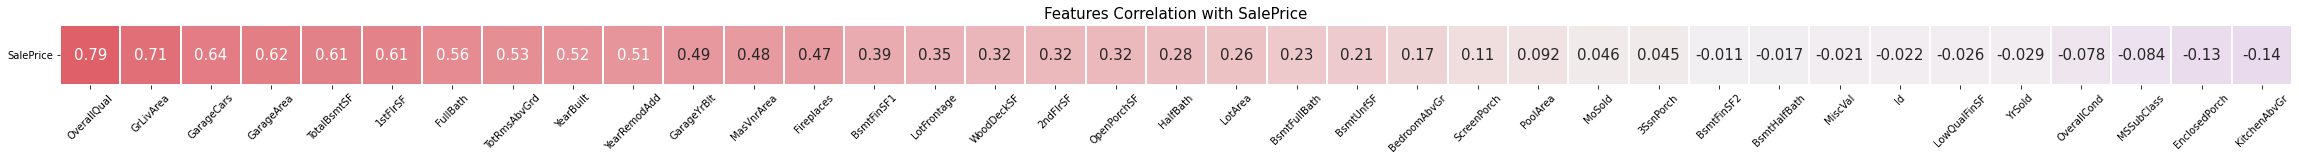

In [ ]:
correlation_info(train_df)

In [ ]:
low_features = ["OverallQual", "GarageCars", "FullBath", "TotRmsAbvGrd"]
high_features= ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", ]

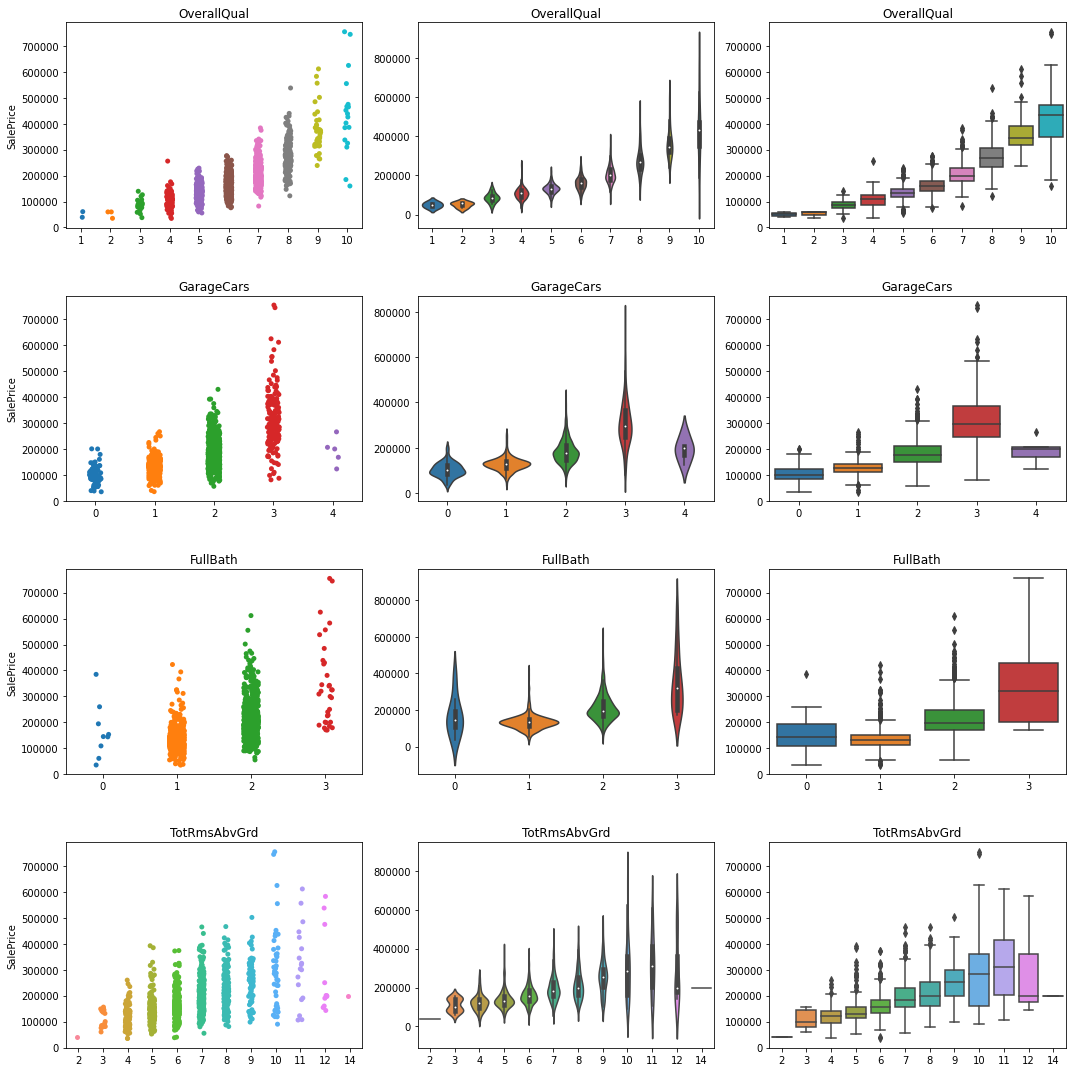

In [ ]:
figure, ax = plt.subplots(len(low_features),3, figsize = (15, 15))
for i, f in enumerate(low_features):
  sns.stripplot(data=train_df, x=f, y='SalePrice', ax = ax[i][0])
  ax[i][0].set(xlabel="", ylabel="SalePrice", title=f)

  sns.violinplot(data=train_df, x=f, y='SalePrice', ax = ax[i][1])
  ax[i][1].set(xlabel="", ylabel="", title=f)

  sns.boxplot(data=train_df, x =f, y='SalePrice', ax = ax[i][2])
  ax[i][2].set(xlabel="", ylabel="", title=f)

plt.tight_layout(h_pad=3.5)
plt.show()

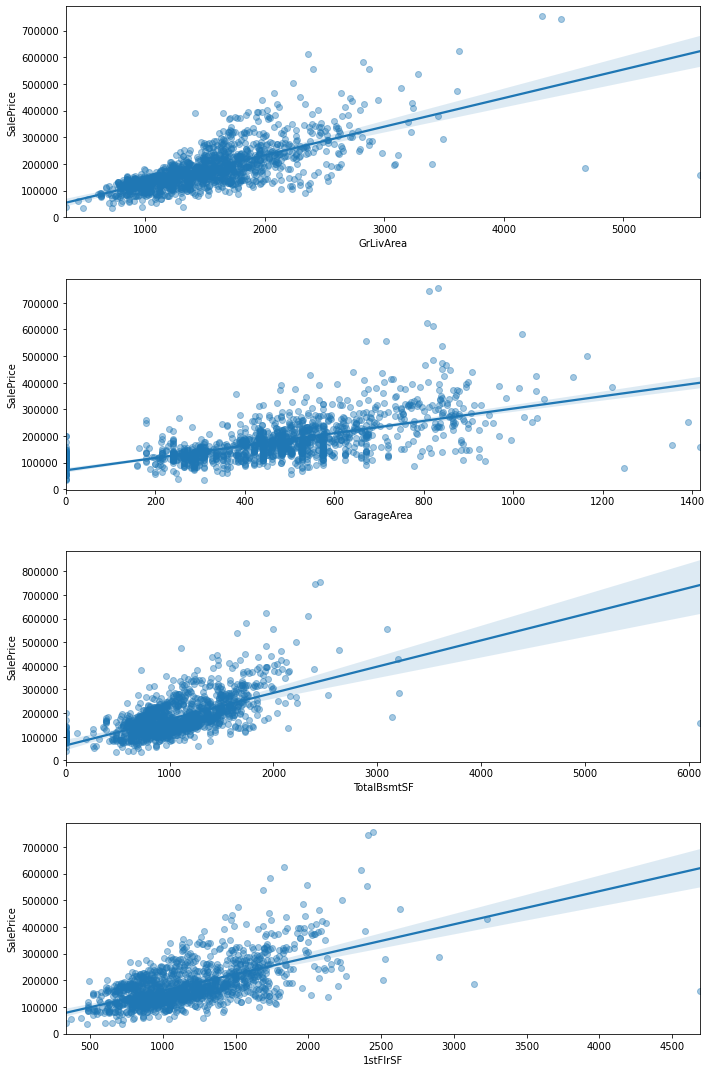

In [ ]:
figure, ax = plt.subplots(len(high_features),1, figsize = (10, 15))
for i, f in enumerate(high_features):
  sns.regplot(data=train_df, x = f, y='SalePrice', scatter_kws={'alpha':0.4}, ax=ax[i])

plt.tight_layout(h_pad=3)
plt.show()

## Cleaning Data

### Cleaning Null Values

In [ ]:
def missing_values_info(df, threshold=0):
    missing = df.isnull().sum().sort_values(ascending = False)
    present = len(df) - df.isnull().sum()
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)
    df_type = df.dtypes
    temp = pd.concat([missing, present, percent, df_type], axis=1, keys= ['Missing', 'Present', 'Percent', 'DTypes'])
    
    return temp.loc[(temp['Percent'] > threshold)]

In [ ]:
missing_info = missing_values_info(train_df)
missing_info

,Missing,Present,Percent,DTypes
PoolQC,1453,7,99.52,object
MiscFeature,1406,54,96.30,object
Alley,1369,91,93.77,object
Fence,1179,281,80.75,object
FireplaceQu,690,770,47.26,object
LotFrontage,259,1201,17.74,float64
GarageCond,81,1379,5.55,object
GarageType,81,1379,5.55,object
GarageYrBlt,81,1379,5.55,float64
GarageFinish,81,1379,5.55,object


In [ ]:
missing_info = missing_values_info(train_df, 20)
missing_info

,Missing,Present,Percent,DTypes
PoolQC,1453,7,99.52,object
MiscFeature,1406,54,96.30,object
Alley,1369,91,93.77,object
Fence,1179,281,80.75,object
FireplaceQu,690,770,47.26,object


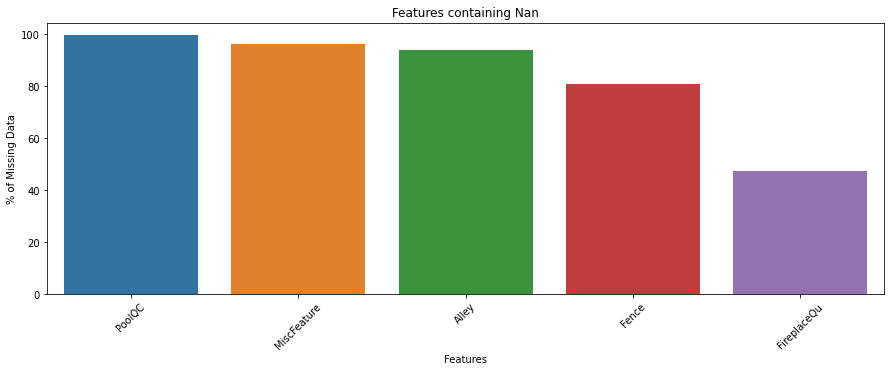

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = missing_info.index, y = missing_info.Percent)
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

In [ ]:
object_features = train_df.select_dtypes(include=['object']).columns
num_features_names = train_df.select_dtypes(include=['float64', "int64"]).columns

train_df[object_features] = train_df[object_features].fillna("Na")
train_df[num_features_names] = train_df[num_features_names].fillna(train_df.mean())

labels1 = ["ExterCond", "ExterQual", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "GarageQual", "GarageCond", "BsmtExposure"]
label_encoding1 = {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, "Na":0}

labels2 = ["BsmtFinType1", "BsmtFinType2"]
label_encoding2 = {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "Na":0}

labels3 = ["LotShape"]
label_encoding3 = {"Reg":1, "IR1":0.66, "IR2":0.33, "IR3":0}

labels4 = ["BsmtExposure"]
label_encoding4 = {"Gd":4, "Av":3, "Mn":2, "No":1, "Na":0}

labels5 = ["Functional"]
label_encoding5 = {"Typ":1, "Min1":0.66, "Min2":0.33, "Mod":0, "Na":0, "Mod":-0.25, "Maj1":-0.5, "Maj2":-0.75, "Sev":-1, "Sal":-1.25}

labels6 = ["PavedDrive"]
label_encoding6 = {"Y":2, "P":1, "N":0}

labels7 = ["GarageFinish"]
label_encoding7 = {"Fin":1, "RFn":0.66, "Unf":0.33, "Na":0}

train_df[labels1] = train_df[labels1].replace(label_encoding1)
train_df[labels2] = train_df[labels2].replace(label_encoding2)
train_df[labels3] = train_df[labels3].replace(label_encoding3)
train_df[labels4] = train_df[labels4].replace(label_encoding4)
train_df[labels5] = train_df[labels5].replace(label_encoding5)
train_df[labels6] = train_df[labels6].replace(label_encoding6)
train_df[labels7] = train_df[labels7].replace(label_encoding7)

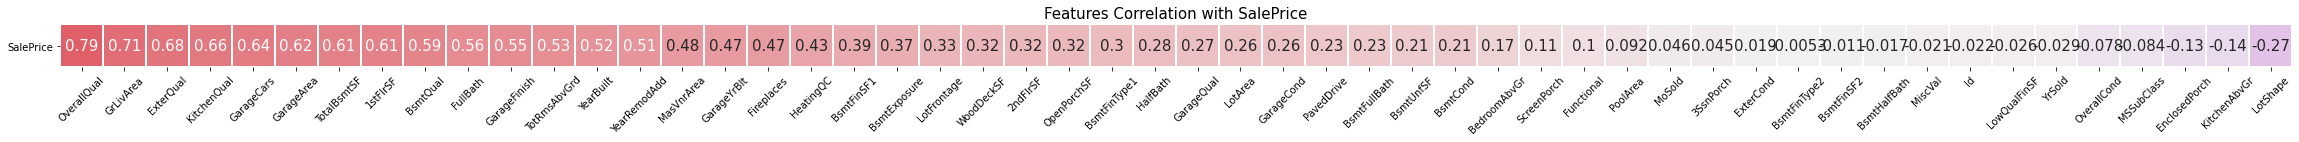

In [ ]:
correlation_info(train_df)

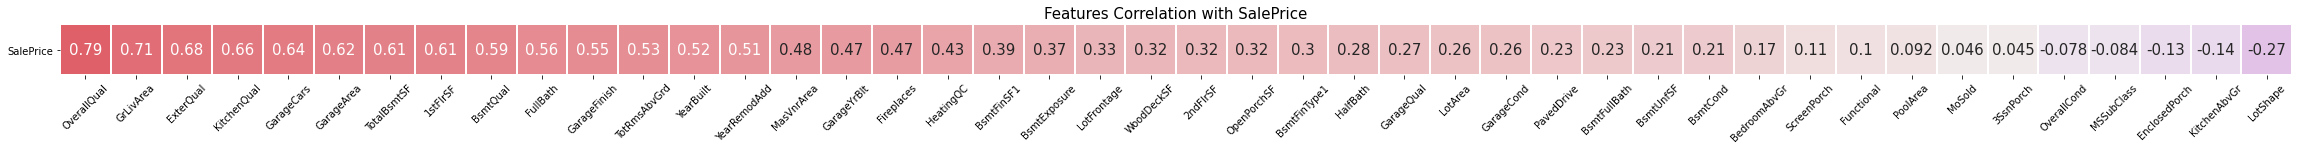

In [ ]:
num_features_names = train_df.select_dtypes(include=['float64', "int64"]).columns
thershold = 0.04
non_correlated_with_output = [column for column in num_features_names if abs(train_df[column].corr(train_df["SalePrice"])) < thershold]
train_df = train_df.drop(non_correlated_with_output, axis=1)
correlation_info(train_df)

In [ ]:
low_features = ["ExterQual", "KitchenQual", "BsmtQual"]

In [ ]:
num_features_names = test_df.select_dtypes(include=['float64', "int64"]).columns
test_df[num_features_names] = test_df[num_features_names].fillna(test_df.mean())
test_df = test_df.fillna("Na")

test_df[labels1] = test_df[labels1].replace(label_encoding1)
test_df[labels2] = test_df[labels2].replace(label_encoding2)
test_df[labels3] = test_df[labels3].replace(label_encoding3)
test_df[labels4] = test_df[labels4].replace(label_encoding4)
test_df[labels5] = test_df[labels5].replace(label_encoding5)
test_df[labels6] = test_df[labels6].replace(label_encoding6)
test_df[labels7] = test_df[labels7].replace(label_encoding7)

test_df = test_df.drop(non_correlated_with_output, axis=1)

In [ ]:
num_train_rows = len(train_df)
full_df = pd.concat([train_df, test_df])
object_features = train_df.select_dtypes(include=['object']).columns
full_df = pd.get_dummies(full_df, columns=object_features)

In [ ]:
new_train_df = full_df[:num_train_rows]
new_test_df = full_df[num_train_rows:]

num_features_names = train_df.select_dtypes(include=['float64', "int64"]).columns
new_train_df[num_features_names] = train_df[num_features_names]

num_features_names = num_features_names.drop("SalePrice")
new_test_df[num_features_names] = test_df[num_features_names]

In [ ]:
def outliers_iqr(ys):
  quartile_1, quartile_3 = np.percentile(ys, [25, 75])
  iqr = quartile_3 - quartile_1
  lower_bound = quartile_1 - (iqr * 1.5)
  upper_bound = quartile_3 + (iqr * 1.5)
  return np.where((ys > upper_bound) | (ys < lower_bound))

trainWithoutOutliers = new_train_df

for column in new_train_df:
  outlierValuesList = np.ndarray.tolist(outliers_iqr(new_train_df[column])[0])
  trainWithoutOutliers = new_train_df.drop(outlierValuesList)
    
new_train_df = trainWithoutOutliers

In [ ]:
X = new_train_df.drop("SalePrice", axis=1)
Y = new_train_df["SalePrice"]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


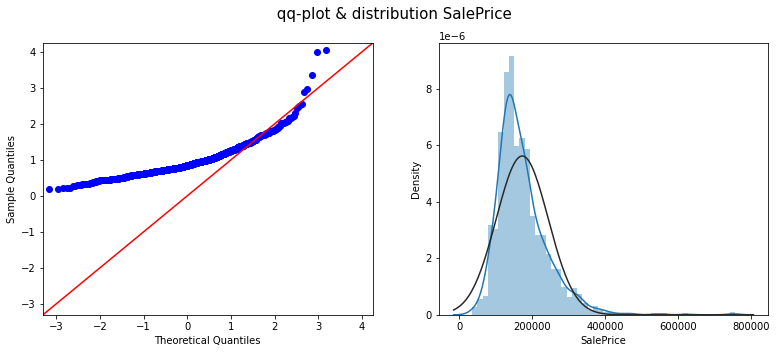

In [ ]:
fig, ax = plt.subplots(1,2, figsize= (13,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(Y, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(Y, kde = True, hist=True, fit=norm, ax = ax[1])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


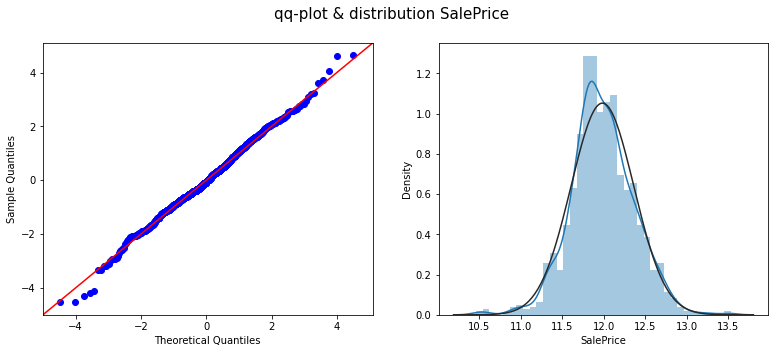

In [ ]:
Y = np.log1p(Y)

fig, ax = plt.subplots(1,2, figsize= (13,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(Y, stats.t, distargs=(4,), fit=True, line="45", ax = ax[0])
sns.distplot(Y, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [ ]:
model = LinearRegression()
reg = model.fit(X, Y)
print("Training Score:", reg.score(X,Y))

Training Score: 0.941651624138213


In [ ]:
test = new_test_df.drop("SalePrice", axis=1) 

pred = reg.predict(test)
pred = np.expm1(pred)

sub = pd.DataFrame()
sub['Id'] = test_final['Id']
sub['SalePrice'] = pred

sub.to_csv("submission.csv", index=False) 

aim["Prediction"] = sub["SalePrice"]
aim["Diference"] = (np.log(aim["Prediction"]) - np.log(aim["SalePrice"]))**2

In [ ]:
print("RMSE Score:", np.sqrt(aim["Diference"].sum()/aim.shape[0]))

RMSE Score: 0.07175499454775949


In [ ]:
aim

,Id,SalePrice,Prediction,Diference
0,1461,122242.0,121136.088662,0.000083
1,1462,163769.0,165610.521614,0.000125
2,1463,184763.0,182711.423925,0.000125
3,1464,199176.0,204256.355300,0.000634
4,1465,191727.0,189216.019243,0.000174
...,...,...,...,...
1454,2915,86790.0,83581.585074,0.001419
1455,2916,80325.0,82595.003216,0.000777
1456,2917,166576.0,167029.110081,0.000007
1457,2918,117101.0,111665.818143,0.002259
